# Imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
import datetime
import warnings 

warnings.filterwarnings('ignore')

# Data Preperation

In [2]:
df = pd.read_csv("../data/USD-EUR-GBP to EGP Time series Data clean.csv",index_col='Date')
df.index = pd.to_datetime(df.index)
df[["USD","EUR","GBP"]] =  df[["USD","EUR","GBP"]].apply(pd.to_numeric)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6241 entries, 2003-12-01 23:58:00 to 2023-03-31 23:58:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USD     6241 non-null   float64
 1   EUR     6241 non-null   float64
 2   GBP     6241 non-null   float64
dtypes: float64(3)
memory usage: 195.0 KB


In [4]:
df.describe()

,USD,EUR,GBP
count,6241.000000,6241.000000,6241.000000
mean,10.600241,12.577217,15.092249
std,5.825124,6.009337,6.371359
min,5.193900,6.462902,7.535949
25%,5.793900,7.792321,10.252250
50%,7.128000,8.980627,11.417500
75%,15.974230,18.659000,21.378700
max,30.950200,33.690000,38.272130


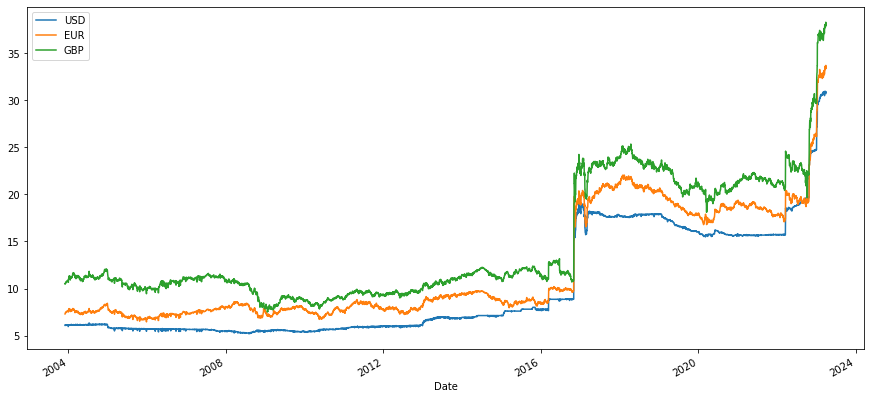

In [5]:
df[["USD","EUR","GBP"]].plot(figsize = (15,7));

#### only take data from dates after 2016 and before 2018, as it is more representing of current data.

In [11]:
df_train = df.loc[datetime.date(year=2016,month=1,day=1):datetime.date(year=2020,month=1,day=1)]

df_test = df.loc[:datetime.date(year=2023,month=4,day=11)]


In [12]:
df_train.index.min() , df_train.index.max()

(Timestamp('2016-01-01 23:58:00'), Timestamp('2019-12-31 23:58:00'))

In [13]:
df_test.index.min() , df_test.index.max()

(Timestamp('2003-12-01 23:58:00'), Timestamp('2023-03-31 23:58:00'))

#### scale each column with Min - Max scaling

In [14]:
scaler = MinMaxScaler(feature_range = (0,1))

In [15]:
df_train_s = pd.DataFrame()
df_train_s[['USDs','EURs','GBPs']] = scaler.fit_transform(df_train)


df_test_s = pd.DataFrame()
df_test_s [['USDs','EURs','GBPs']] = scaler.fit_transform(df_test)


In [16]:
df_train.describe()

,USD,EUR,GBP
count,1460.000000,1460.000000,1460.000000
mean,15.598962,17.747050,20.394722
std,3.672944,4.361177,4.595024
min,7.645900,8.330132,10.689083
25%,16.098890,17.811000,20.114750
50%,17.605000,19.599335,22.712550
75%,17.860000,20.720705,23.352007
max,19.603000,22.046214,25.340547


In [17]:
df_test.describe()

,USD,EUR,GBP
count,6241.000000,6241.000000,6241.000000
mean,10.600241,12.577217,15.092249
std,5.825124,6.009337,6.371359
min,5.193900,6.462902,7.535949
25%,5.793900,7.792321,10.252250
50%,7.128000,8.980627,11.417500
75%,15.974230,18.659000,21.378700
max,30.950200,33.690000,38.272130


#### split into features and labels

In [18]:
x_train = df_train_s.to_numpy()
y_train = df_train_s.iloc[:,0].to_numpy()

x_test = df_test_s.to_numpy()
y_test = df_test_s.iloc[:,0].to_numpy()

#### ( 2016 - 2020 ) training data

In [19]:
x_train.shape

(1460, 3)

In [20]:
y_train.shape

(1460,)

#### testing data ~ ( 2003 -  2023)

In [21]:
x_test.shape

(6241, 3)

In [22]:
y_test.shape

(6241,)

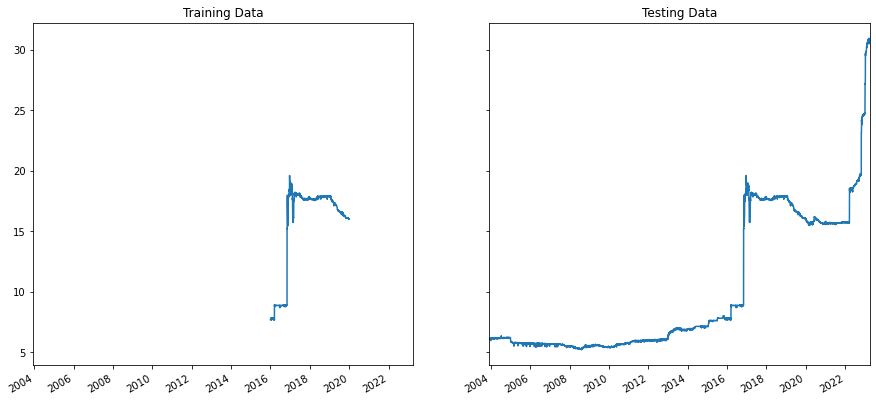

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey = True,figsize = (15,7))


ax1.plot(df_train.index.to_pydatetime() ,df_train[["USD"]]);

ax2.plot(df_test.index.to_pydatetime() ,df_test[["USD"]]);

fig.autofmt_xdate()

ax1.set_xlim([df.index.min(), df.index.max()]);
ax2.set_xlim([df.index.min(), df.index.max()]);
ax1.set_title("Training Data");
ax2.set_title("Testing Data");

# 3.0 Modeling

#### Create generator for testing and tranning

In [50]:
days_found = 9
days_to_find =1
days = days_to_find + days_found
train_generator = TimeseriesGenerator(
    x_train,
    y_train,
    length = days,
    sampling_rate= 1,
    batch_size = 10
)
test_generator = TimeseriesGenerator(
    x_test,
    y_test,
    length = days,
    sampling_rate= 1,
    batch_size = 10
)

#### Model 

In [51]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128 , input_shape = (days,3),return_sequences =True))
model.add(tf.keras.layers.LSTM(64 , return_sequences = False))
model.add(tf.keras.layers.Dense(16,activation='LeakyReLU'))
model.add(tf.keras.layers.Dense(1,activation='linear'))

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 128)           67584     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 118,049
Trainable params: 118,049
Non-trainable params: 0
_________________________________________________________________


#### Use MAE as loss function
and moniter RMSE, MSE

In [53]:
model.compile(
            loss = tf.losses.MeanAbsoluteError(),
            optimizer = tf.optimizers.Adagrad(),
            metrics = [
                        tf.keras.metrics.RootMeanSquaredError(),
                        tf.keras.metrics.MeanAbsoluteError(),
                        tf.keras.metrics.MeanSquaredError()
                      ]
             ) 

In [54]:
history = model.fit_generator(train_generator, epochs = 250, validation_data = test_generator,shuffle = False)           

Epoch 1/250
145/145 [==============================] - 10s 40ms/step - loss: 0.3071 - root_mean_squared_error: 0.4041 - mean_absolute_error: 0.3071 - mean_squared_error: 0.1633 - val_loss: 0.2220 - val_root_mean_squared_error: 0.2386 - val_mean_absolute_error: 0.2220 - val_mean_squared_error: 0.0569
Epoch 2/250
145/145 [==============================] - 4s 24ms/step - loss: 0.0683 - root_mean_squared_error: 0.1180 - mean_absolute_error: 0.0683 - mean_squared_error: 0.0139 - val_loss: 0.1946 - val_root_mean_squared_error: 0.2090 - val_mean_absolute_error: 0.1946 - val_mean_squared_error: 0.0437
Epoch 3/250
145/145 [==============================] - 3s 23ms/step - loss: 0.0611 - root_mean_squared_error: 0.1056 - mean_absolute_error: 0.0611 - mean_squared_error: 0.0111 - val_loss: 0.1773 - val_root_mean_squared_error: 0.1895 - val_mean_absolute_error: 0.1773 - val_mean_squared_error: 0.0359
Epoch 4/250
145/145 [==============================] - 4s 29ms/step - loss: 0.0553 - root_mean_squa

# Evaluate

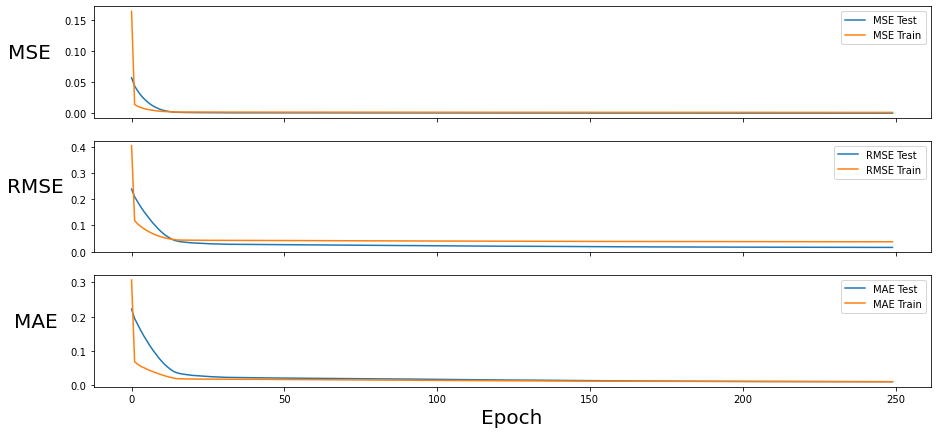

In [55]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex = True,figsize = (15,7))

ax1.plot(history.history["val_mean_squared_error"]);
ax1.plot(history.history["mean_squared_error"]);

ax2.plot(history.history["val_root_mean_squared_error"]);
ax2.plot(history.history["root_mean_squared_error"]);


ax3.plot(history.history["val_mean_absolute_error"]);
ax3.plot(history.history["mean_absolute_error"]);

ax1.set_ylabel('MSE',Rotation =0, fontsize=20,labelpad=35)
ax2.set_ylabel('RMSE',Rotation =0, fontsize=20,labelpad=35)
ax3.set_ylabel('MAE',Rotation =0, fontsize=20,labelpad=35)

ax3.set_xlabel('Epoch', fontsize=20)

ax1.legend(['MSE Test','MSE Train'],loc='upper right')
ax2.legend(['RMSE Test','RMSE Train'],loc='upper right')
ax3.legend(['MAE Test','MAE Train'],loc='upper right')

plt.show()


In [56]:
for i in model.metrics_names:
    print(i,round(history.history[i][-1],5),"Train")
    print("val_"+i,round(history.history["val_"+i][-1],5),"Test\n")

loss 0.01016 Train
val_loss 0.01012 Test

root_mean_squared_error 0.03748 Train
val_root_mean_squared_error 0.01591 Test

mean_absolute_error 0.01016 Train
val_mean_absolute_error 0.01012 Test

mean_squared_error 0.0014 Train
val_mean_squared_error 0.00025 Test



#### reverse the normilization
#### add the predicted values to the original values
and plot both

Make predictions from the testing generator and concatinate it to the original values

In [57]:
predictions = model.predict_generator(test_generator)
predictions.shape[0]

6231

In [58]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][days:])] , axis = 1)

In [59]:
df_pred

,0,0,1
0,0.033699,0.038303,0.101221
1,0.033836,0.040581,0.105262
2,0.034101,0.041403,0.106335
3,0.034286,0.040671,0.105969
4,0.034402,0.040780,0.105969
...,...,...,...
6226,0.943940,0.989128,0.991019
6227,0.945055,0.992691,0.994495
6228,0.946244,0.989349,0.988693
6229,0.946494,1.000000,1.000000


reverse the normilization

In [60]:
rev_trans = scaler.inverse_transform(df_pred)

In [61]:
df_end = df[predictions.shape[0]*-1:]
df_end

,USD,EUR,GBP
Date,,,
2003-12-15 23:58:00,6.09730,7.505776,10.647105
2003-12-16 23:58:00,6.14170,7.567803,10.771313
2003-12-17 23:58:00,6.12210,7.590180,10.804282
2003-12-18 23:58:00,6.09570,7.570250,10.793046
2003-12-19 23:58:00,6.11780,7.573225,10.793023
...,...,...,...
2023-03-27 23:58:00,30.89910,33.394000,37.996090
2023-03-28 23:58:00,30.90850,33.491000,38.102930
2023-03-29 23:58:00,30.80190,33.400000,37.924590


In [62]:
df_end["USD-predict"] = rev_trans[:,0]

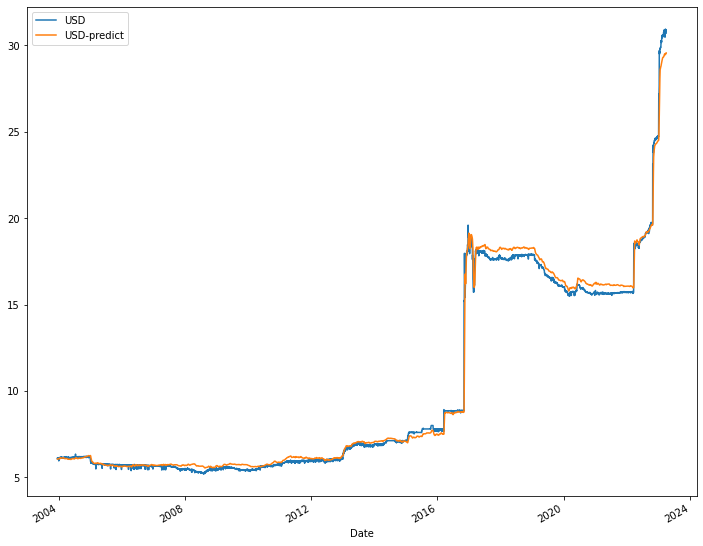

In [63]:
df_end[["USD","USD-predict"]].plot(figsize = (12,10));

# Use the presaved model
- trained on 250 epochs
- as MAE as loss function

In [64]:
model.save("modelG")

INFO:tensorflow:Assets written to: modelG\assets


INFO:tensorflow:Assets written to: modelG\assets


In [65]:
model = keras.models.load_model('modelG')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 128)           67584     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 118,049
Trainable params: 118,049
Non-trainable params: 0
_________________________________________________________________
